In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, concatenate
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [3]:
#doses pulled from Data Analysis/CLOCK_DATA/ACLK Graph to match LPM0,2,4 on first 11 trials - maybe automate this later
doses = np.array([ 0.  ,  5.44, 10.88, 16.32, 21.76, 27.2 , 32.64, 38.08, 43.52,
       48.96, 54.4 , 59.84,  0.  ,  5.44, 10.88, 16.32, 21.76, 27.2 ,
       32.64, 38.08, 43.52, 48.96, 54.4 , 59.84,  0.  ,  5.44, 10.88,
       16.32, 21.76, 27.2 , 32.64, 38.08, 43.52, 48.96, 54.4 , 59.84])
classes = ["0-16.32", "16.32-43.52", "43.52+"]

In [4]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [5]:
#load data
trial_path = "/Users/trevorpeyton/Downloads/"
trial_numbers = np.arange(12)
channels = ["Channel1"]
modes = ["LPM0", "LPM2", "LPM4"]
trial_labels = [(f"{channel}/{mode}_Trial{number}", mode) for mode in modes for number in trial_numbers for channel in channels] #modified to pass along mode
trials = [(pd.read_csv(trial_path + label + ".csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()[::], mode) for label, mode in trial_labels] #(data, mode)

trial_slde_width = 2000
test_percent = .2
val_percent = .2 #percent of test set to be reserved for validation


temp_df = {"data": [], "class": [], "mode": []}

for i, (trial, mode) in enumerate(trials):
    #normalize all values using z-score
    trial_copy = np.zeros(trial.shape)
    trial_copy[trial > 2] = (trial[trial > 2] - trial[trial > 2].mean()) / trial[trial > 2].std()
    trial_copy[trial < 2] = (trial[trial < 2] - trial[trial < 2].mean()) / trial[trial < 2].std()
    for win in np.lib.stride_tricks.sliding_window_view(trial_copy, trial_slde_width)[::int(trial_slde_width / 2)]:
        temp_df["data"].append(win)
        temp_df["mode"].append(mode)
        if doses[i] >= 43:
            temp_df["class"].append(classes[2])
        elif doses[i] > 17:
            temp_df["class"].append(classes[1])
        else:
            temp_df["class"].append(classes[0])

df = pd.DataFrame(temp_df)
df["merged_strat"] = df["mode"] + df["class"]

#split train/test/val
temp_train, temp_test = train_test_split(df, test_size = test_percent, random_state=2, stratify=df["merged_strat"])
temp_test, temp_val = train_test_split(temp_test, test_size = val_percent, random_state=2, stratify=temp_test["merged_strat"])

train = np.concatenate((pd.get_dummies(temp_train["mode"], columns=modes).values, np.stack(temp_train["data"])), axis=1)
train_y = pd.get_dummies(temp_train["class"], columns=classes).values
test = np.concatenate((pd.get_dummies(temp_test["mode"], columns=modes).values, np.stack(temp_test["data"])), axis=1)
test_y = pd.get_dummies(temp_test["class"], columns=classes).values
val = np.concatenate((pd.get_dummies(temp_val["mode"], columns=modes).values, np.stack(temp_val["data"])), axis=1)
val_y = pd.get_dummies(temp_val["class"], columns=classes).values

df = trials = temp_df = temp_train = temp_test = temp_val = None #clear up some memory

In [6]:
mode_input = Input(shape=(len(modes), ))
data_input = Input(shape=(train.shape[1] - len(modes), 1))

conv_1 = Conv1D(16, train.shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                )(data_input)
max_1 = MaxPooling1D(8)(conv_1)

conv_2 = Conv1D(8, train.shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                )(max_1)
max_2 = MaxPooling1D(8)(conv_2)

flatten = Flatten()(max_2)
dropout = Dropout(0.5)(flatten)

combined = keras.layers.Concatenate()([mode_input, dropout])
final = Dense(3)(combined)

model = Model(inputs=[mode_input, data_input], outputs=final)

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    metrics = ["accuracy"]
    )

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-22 23:15:30.980622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-22 23:15:30.980710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:

#plot_model(model, show_shapes=True, show_layer_names=True)
history = model.fit([train[:, 0:3, None], train[:, 3:, None]], train_y, batch_size=1024, epochs=25, verbose=1, validation_data=([val[:, 0:3, None], val[:, 3:, None]], val_y))

Epoch 1/25


2022-03-22 23:15:34.557223: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 23:15:34.806096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 1s/step - loss: 2.3541 - accuracy: 0.3324 - val_loss: 2.1641 - val_accuracy: 0.4648
Epoch 2/25


2022-03-22 23:15:38.353331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 953ms/step - loss: 2.1322 - accuracy: 0.4805 - val_loss: 1.9208 - val_accuracy: 0.6056
Epoch 3/25
2/2 [==============================] - 3s 944ms/step - loss: 1.8990 - accuracy: 0.5372 - val_loss: 1.6435 - val_accuracy: 0.7746
Epoch 4/25
2/2 [==============================] - 3s 952ms/step - loss: 1.6187 - accuracy: 0.6754 - val_loss: 1.4440 - val_accuracy: 0.7606
Epoch 5/25
2/2 [==============================] - 3s 944ms/step - loss: 1.4324 - accuracy: 0.7094 - val_loss: 1.2777 - val_accuracy: 0.7887
Epoch 6/25
2/2 [==============================] - 3s 953ms/step - loss: 1.2703 - accuracy: 0.7597 - val_loss: 1.1376 - val_accuracy: 0.8310
Epoch 7/25
2/2 [==============================] - 3s 942ms/step - loss: 1.1374 - accuracy: 0.7980 - val_loss: 1.0441 - val_accuracy: 0.8169
Epoch 8/25
2/2 [==============================] - 3s 988ms/step - loss: 1.0396 - accuracy: 0.8086 - val_loss: 0.9588 - val_accuracy: 0.8169
Epoch 9/25
2/2 [===============

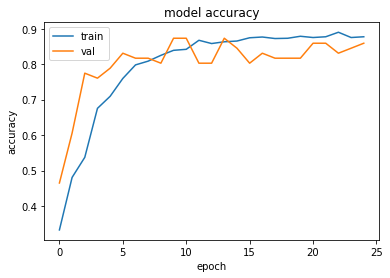

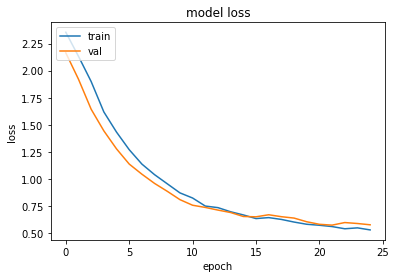

In [8]:
_=plt.figure(facecolor='white')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

_=plt.figure(facecolor='white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
print(f"{model.evaluate([test[:, 0:3, None], test[:, 3:, None]], test_y)}")

9/9 [==============================] - 0s 28ms/step - loss: 0.5483 - accuracy: 0.8546
[0.5482701063156128, 0.8546099662780762]


In [12]:
#show some predictions from test dataset
start = 40
predictions = 20
for n in range(start, start+predictions):
    print(f"\tPredicted: {np.argmax(model([test[None, n, 0:3, None], test[None, n, 3:, None]]), axis=1)}, expected: {np.argmax(test_y[n])}")

	Predicted: [1], expected: 1
	Predicted: [0], expected: 1
	Predicted: [2], expected: 2
	Predicted: [1], expected: 1
	Predicted: [1], expected: 1
	Predicted: [0], expected: 0
	Predicted: [1], expected: 1
	Predicted: [2], expected: 2
	Predicted: [0], expected: 0
	Predicted: [2], expected: 2
	Predicted: [1], expected: 1
	Predicted: [1], expected: 1
	Predicted: [2], expected: 1
	Predicted: [0], expected: 0
	Predicted: [0], expected: 0
	Predicted: [0], expected: 0
	Predicted: [2], expected: 2
	Predicted: [1], expected: 1
	Predicted: [1], expected: 1
	Predicted: [0], expected: 0


In [ ]:
for n, model in enumerate(models):
    model.save(f"models/classification_{modes[n]}.h5")